# Epsilon Stability and K (GAAS Subspace Dimension)

Here we investigate whether the dimension k of adversarial subspaces for AE tend to be larger than those of "clean" (unmodified) examples in the case when AE occupy the \epsilon-stable region of the clean example.  Part of our motivation is to determine whether "k-stability" is a reasonable detector for AE having small perturbation.

For a precise definition of \epsilon-stable, please see our writeup.

In [1]:
%matplotlib inline

import sys
import os
import time
import numpy as np
import pylab as plt
import pandas as pd
plt.rcParams['figure.figsize'] = (16,9)
from matplotlib import colors

import mpl_toolkits.mplot3d.art3d as art3d

sys.path.append("..")
import data_utils as du

### Helper functions

In [12]:
def finite_part(x):
    "Returns a copy of x with all NaN elements removed."
    return x[np.isfinite(x)]



def estimate_epsilon_stability(df, e_id, dataset, fudge_factor=5.0, large_constant=4.0):
    """ Estimates the epsilon stability of a point.
    """
    # grab "gaussian" directions originating from the example
    subset = (df['Example#'] == e_id) & (df['direction_type'] == 'gaussian') & (df['Dataset'] == dataset)

    # Generate an estimate for the \epsilon stable region.
    # (we'll scale it later on below)
    epsilon_est = np.min(df[subset]['boundary_distance'])
    
    # do something about inf distances
    epsilon_est = large_constant if not np.isfinite(epsilon_est) else epsilon_est
    
    # apply scaling factor
    return epsilon_est / fudge_factor
    
    

def estimate_k_gaas(df, e_id, dataset, epsilon_ref):
    """ Estimates the dimension k of a "largest" local linear adversarial subspace.
        This estimate is a bit crude because it is limited by the k values/directions 
        that were pre-computed.
    """
    # grab subset of data corresponding to this example/point type
    gaas_idx = (df['Example#'] == e_id) & (df['direction_type'] == 'gaas') & (df['Dataset'] == dataset)
    subset = df[gaas_idx]
    
    if len(subset) == 0:
        return None
    
    # Search for k.
    k_all = pd.unique(subset['k'])
    k_est = 0
    
    for k in k_all:
        # determine how many GASS directions successfully produce AE
        # by moving <= epsilon_ref
        tmp = subset[subset['k'] == k]
        freq = np.sum(tmp['boundary_distance'] <= epsilon_ref)
        
        # decide how many successes are required to say the
        # subspace is dimension k.
        #if freq < (k/2.0):  # at least half successful
        if freq < k:  # all are successful
        #if freq == 0:  # at least one must succeed
            break # too many directions were ineffective; terminate search
        else:
            k_est = k   # keep going
            
    return k_est 


#---------------------------------------------------------------------------------
# Plotting codes
#---------------------------------------------------------------------------------

def scatter_finite(a, b, sigma=0):
    "Generates a scatter plot using only the finite parts of vectors a and b."
    idx = np.isfinite(a) & np.isfinite(b)
    x = a[idx] + np.random.randn(np.sum(idx)) * sigma
    y = b[idx] + np.random.randn(np.sum(idx)) * sigma
    plt.scatter(x, y)
    
    
def scatter3_2d(x, y, z):
    is_nonneg = (z >= 0)
    
    mag = abs(z)
    mag[mag < 1] = 1;
    
    plt.scatter(x[is_nonneg], y[is_nonneg], s=mag[is_nonneg], c=[.05, .7, .9], alpha=0.5, marker="o")
    plt.scatter(x[~is_nonneg], y[~is_nonneg], s=mag[~is_nonneg], c=[.9, .7, .1], alpha=0.5, marker="o")
    

    
def compare_distributions(a, b, names=["a", 'b']):
    """Compares two distributions.  
    Assumes eps_a, eps_B are vectors whose indices correspond to the same underlying clean example.
    In other words, eps_a[i] and eps_b[i] share the same underlying clean example.
    """
    
    idx = np.isfinite(a) & np.isfinite(b)
    
    plt.figure()
    
    if False: # overlaid distributions are hard to read for this data
        tmp = np.concatenate((a[idx], b[idx]))
        bins = np.linspace(np.min(tmp), np.max(tmp), 100)

        plt.hist(a[idx], bins, alpha=0.5, label=names[0])
        plt.hist(b[idx], bins, alpha=0.5, label=names[1])
        plt.legend(loc="upper right")
    else:
        plt.subplot(1,2,1)
        plt.hist(a[idx]); plt.title(names[0]);  plt.grid('on')
        plt.subplot(1,2,2)
        plt.hist(b[idx]); plt.title(names[1]);  plt.grid('on')
        
        
def stem3(x, y, z):
    # Requires Axis3D
    fig = plt.figure();
    ax = fig.add_subplot(111, projection='3d')

    for xi, yi, zi in zip(x, y, z):        
        line=art3d.Line3D(*zip((xi, yi, 0), (xi, yi, zi)), marker='o', markevery=(1, 1))
        ax.add_line(line)
        
    ax.set_xlim3d(np.min(x), np.max(x))
    ax.set_ylim3d(np.min(y), np.max(y))
    ax.set_zlim3d(np.min(z), np.max(z))


In [3]:
#=================================================================================
# Load data
#=================================================================================

df = pd.read_pickle(os.path.expanduser("~/Data/Data_for_Evans_CIFAR_Experiments/Feb_9_2018_ell2/cifar10_stats_df_CH.pkl"))

print(df.dtypes.index)

all_datasets = pd.unique(df['Dataset'])
all_examples = pd.unique(df['Example#'])
all_examples = np.sort(all_examples)

d_max = np.max(finite_part(df['boundary_distance']))  # largest non-inf distance to a boundary


print('frame has %d datasets and %d unique examples' % (len(all_datasets), len(all_examples)))
print('k: ', pd.unique(df['k']))
print('d_max : ', d_max)
print(all_datasets)
df.head()

Index(['Approx_conf', 'Dataset', 'Example#', 'boundary_distance', 'delta_l2',
       'delta_loss', 'direction_id', 'direction_type', 'ell2_grad', 'k', 'y',
       'y_hat'],
      dtype='object')
frame has 21 datasets and 168 unique examples
k:  [ nan   2.   3.   4.   5.   7.  10.  15.  20.  30.]
d_max :  39.9985256663
['cifar10' 'FGM-10.00' 'FGM-2.50' 'FGM-5.00' 'I-FGM-1.50' 'I-FGM-10.00'
 'I-FGM-2.00' 'I-FGM-2.50' 'I-FGM-5.00' 'FGM-0.30' 'FGM-0.50' 'FGM-0.75'
 'FGM-1.00' 'FGM-1.50' 'FGM-2.00' 'I-FGM-0.30' 'I-FGM-0.50' 'I-FGM-0.75'
 'I-FGM-1.00' 'I-FGM-0.20' 'FGM-0.20']


,Approx_conf,Dataset,Example#,boundary_distance,delta_l2,delta_loss,direction_id,direction_type,ell2_grad,k,y,y_hat
0,2.384989,cifar10,0,2.248105,NaN,1.184469,NaN,gradient,0.484421,NaN,3,1.0
1,2.384989,cifar10,0,inf,NaN,NaN,NaN,neg-gradient,0.484421,NaN,3,NaN
2,2.384989,cifar10,0,10.786918,NaN,1.111750,NaN,gaussian,0.484421,NaN,3,6.0
3,2.384989,cifar10,0,16.394444,NaN,1.034890,NaN,gaussian,0.484421,NaN,3,6.0
4,2.384989,cifar10,0,16.801848,NaN,1.163014,NaN,gaussian,0.484421,NaN,3,6.0


In [4]:
#=================================================================================
# Compute stability estimates for each clean example.
#=================================================================================

epsilon_clean = np.zeros((len(all_examples),))
k_max_clean = np.zeros((len(all_examples),))


tic = time.time()
subset = df[df['Dataset'] == 'cifar10']  # speeds up calculations later

for idx, e_id in enumerate(all_examples):
    epsilon_clean[idx] = estimate_epsilon_stability(subset, e_id, 'cifar10', large_constant=2*d_max)
    k_max_clean[idx] = estimate_k_gaas(subset, e_id, 'cifar10', epsilon_clean[idx])
    
print('Took %0.2f seconds to compute stability metrics for clean' % (time.time() - tic))

Took 4.86 seconds to compute stability metrics for clean


                  boundary_distance     k  delta_l2
Example# Dataset                                   
0        cifar10           1.416139   0.0       NaN
1        cifar10           0.538671   4.0       NaN
2        cifar10           0.984099  20.0       NaN
3        cifar10           0.591606   3.0       NaN
4        cifar10           2.957406   4.0       NaN
(168, 3)
(168,)
0.0


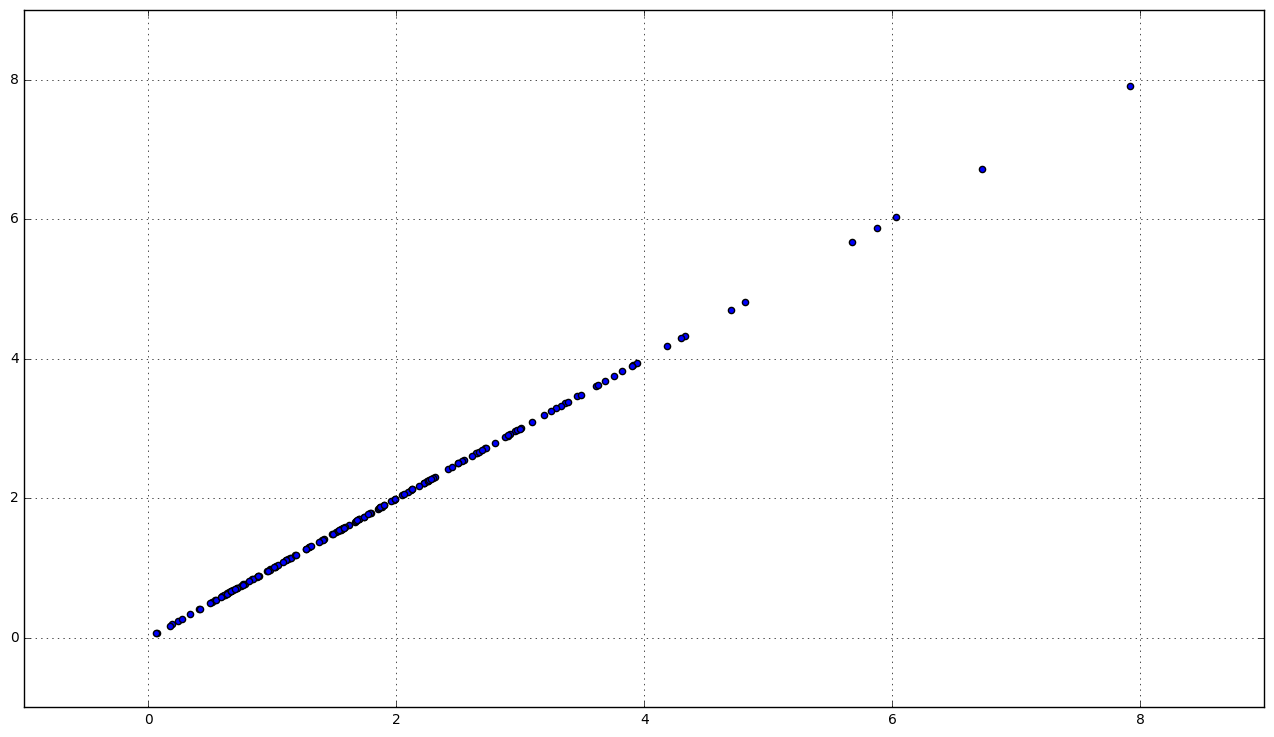

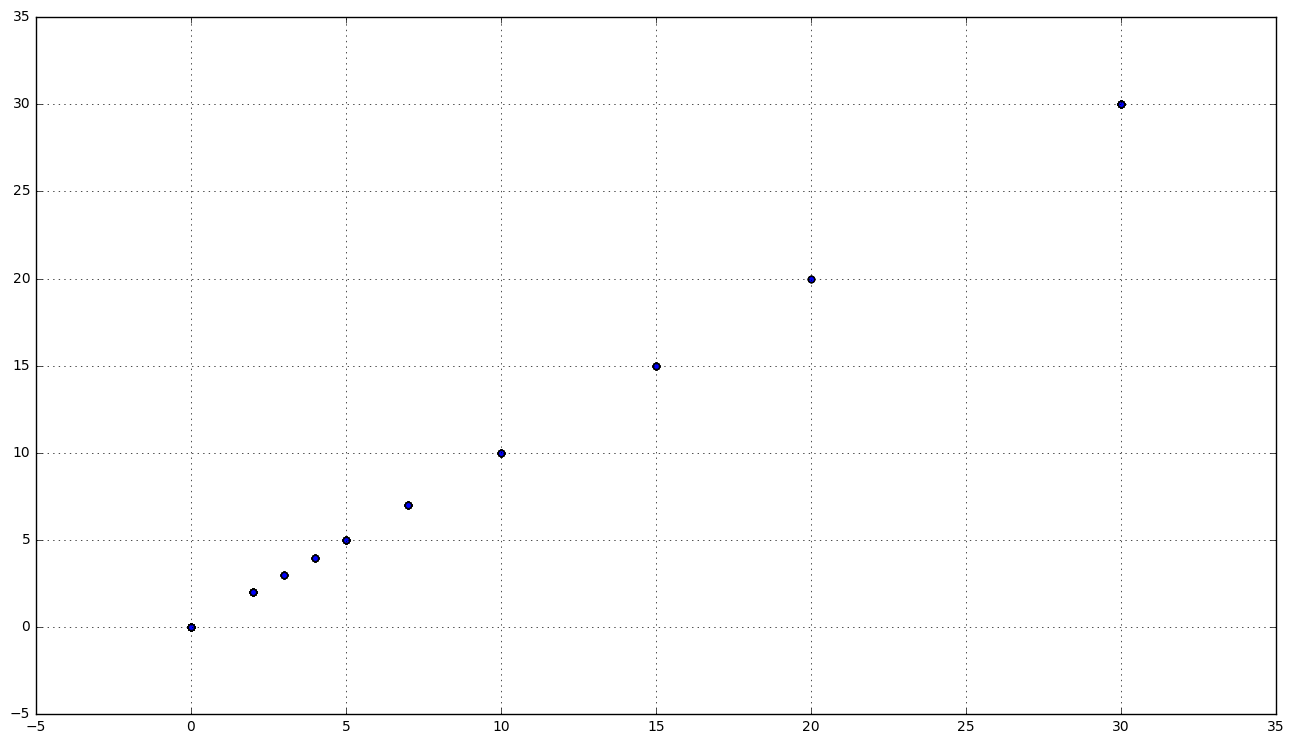

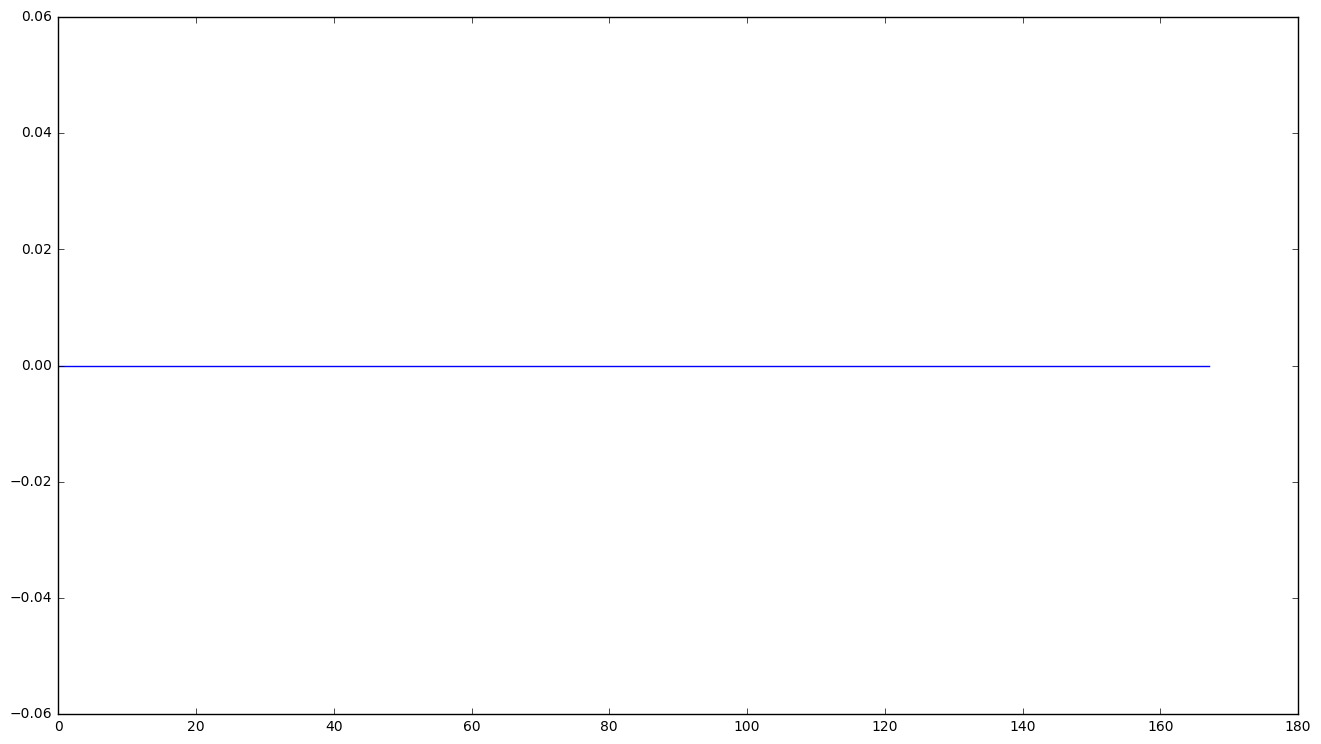

In [5]:
# double check our calculations
eps2 = du.calculate_stability(subset, 5)  # TEMP - if we want to triple-check

print(eps2.head())
print(eps2.shape)
print(epsilon_clean.shape)

plt.figure()
plt.scatter(eps2['boundary_distance'], epsilon_clean)
plt.grid('on')

plt.figure()
plt.scatter(eps2['k'], k_max_clean)
plt.grid('on')

delta = eps2['k'] - k_max_clean
print(np.min(delta))

plt.figure()
plt.plot(np.array(delta))

plt.show()


there are 168 clean examples total


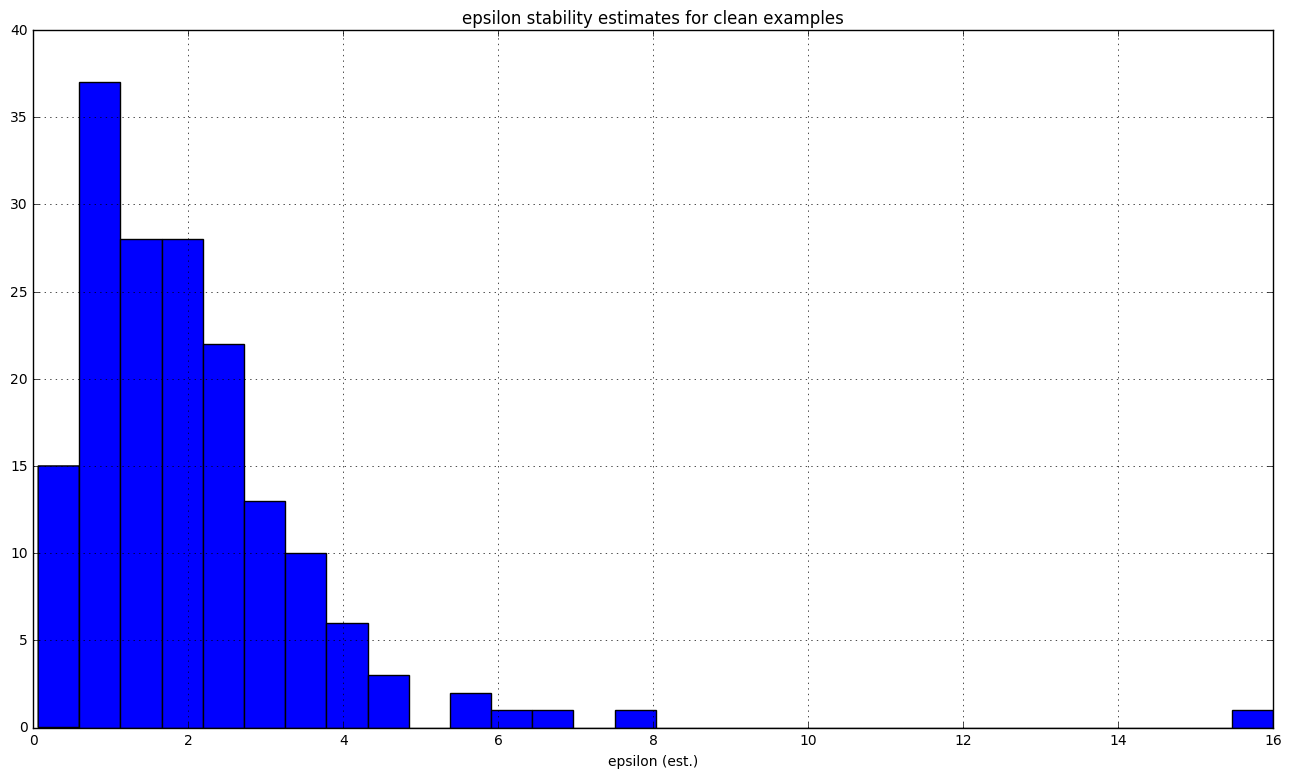

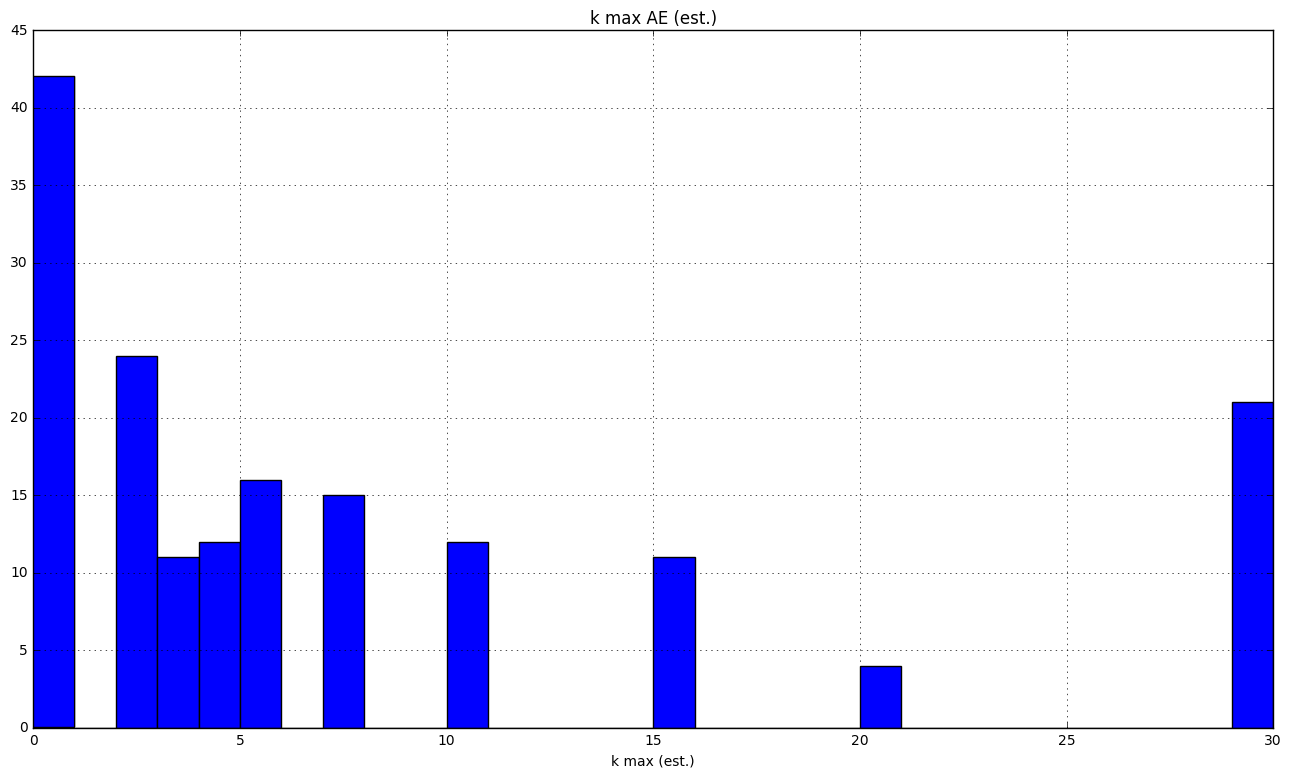

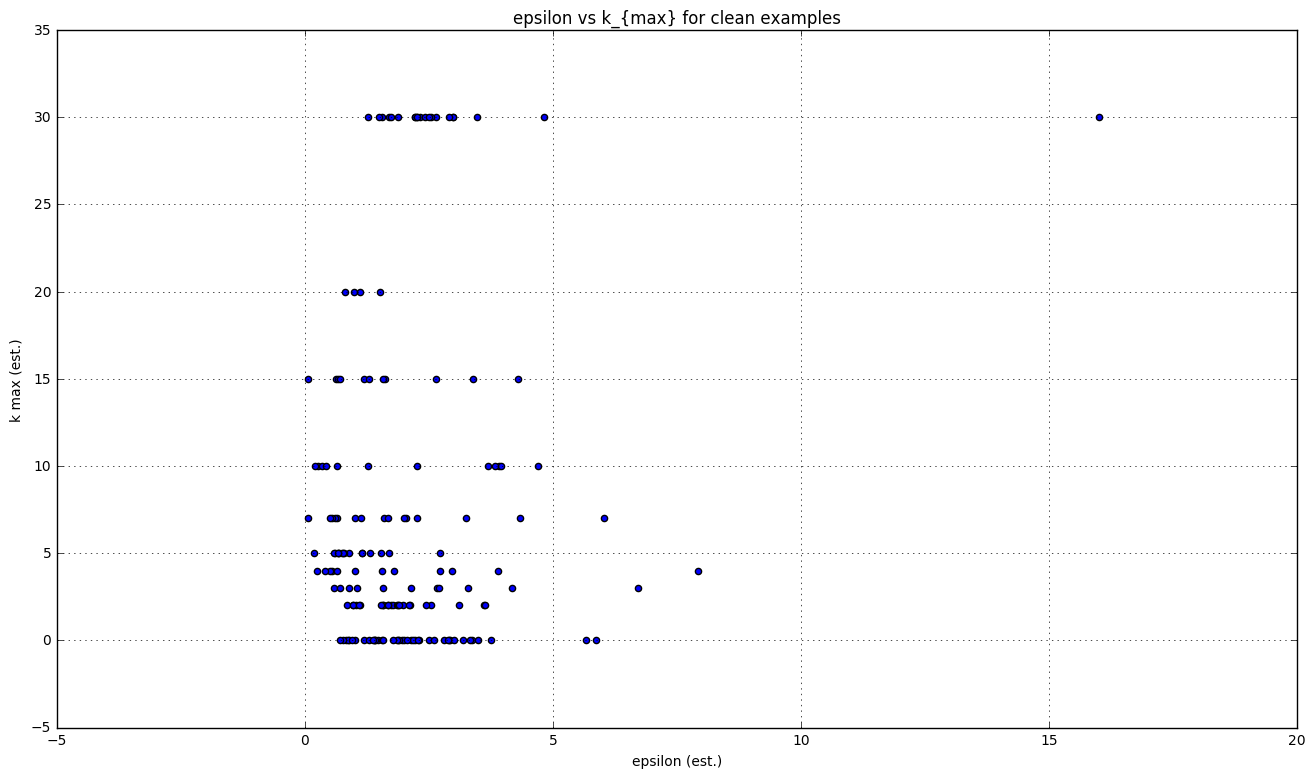

In [6]:
#=================================================================================
# Some statistics related to \epsilon-stability
#=================================================================================

print('there are %d clean examples total' % epsilon_clean.size)

plt.figure()
plt.hist(epsilon_clean, 30)
plt.xlabel('epsilon (est.)')
plt.title('epsilon stability estimates for clean examples')
plt.grid('on')


plt.figure()
plt.title('k max AE (est.)')
plt.hist(k_max_clean, 30)
plt.xlabel('k max (est.)')
plt.grid('on')

plt.figure()
plt.title('epsilon vs k_{max} for clean examples')
plt.scatter(epsilon_clean, k_max_clean)
plt.xlabel('epsilon (est.)')
plt.ylabel('k max (est.)')
plt.grid('on')

plt.show()


In [7]:
#=================================================================================
# Stability estimates for AE
#=================================================================================

delta_ae = {}
epsilon_ae = {}
k_max_ae = {}


tic = time.time()

for data_set in all_datasets:
    if data_set == 'cifar10':
        continue # we already did this above
        
    this_data_set = df[df['Dataset'] == data_set]
        
    epsilon_i = np.nan * np.zeros((len(all_examples),))
    k_max_i = np.nan * np.zeros((len(all_examples),))
    delta_i = np.nan * np.zeros((len(all_examples),))
    
    
    for idx, e_id in enumerate(all_examples):
        subset = this_data_set[this_data_set['Example#'] == e_id]
        
        if len(subset) == 0:
            continue
            
        delta_i[idx] = np.median(subset['delta_l2']) # these values should all be same; median just picks one
        epsilon_i[idx] = estimate_epsilon_stability(subset, e_id, data_set, large_constant=2*d_max)
        k_max_i[idx] = estimate_k_gaas(subset, e_id, data_set, epsilon_clean[idx])  # note: reference stability is for *clean* example!
        

    print('Finished with %s; net runtime: %0.2f sec' % (data_set, time.time()-tic))
    epsilon_ae[data_set] = epsilon_i
    k_max_ae[data_set] = k_max_i
    delta_ae[data_set] = delta_i
    
print('done: total runtime was %0.2f sec' % (time.time()-tic))

Finished with FGM-10.00; net runtime: 1.79 sec
Finished with FGM-2.50; net runtime: 3.39 sec
Finished with FGM-5.00; net runtime: 4.86 sec
Finished with I-FGM-1.50; net runtime: 6.31 sec
Finished with I-FGM-10.00; net runtime: 7.97 sec
Finished with I-FGM-2.00; net runtime: 9.66 sec
Finished with I-FGM-2.50; net runtime: 11.36 sec
Finished with I-FGM-5.00; net runtime: 12.85 sec
Finished with FGM-0.30; net runtime: 13.38 sec
Finished with FGM-0.50; net runtime: 14.14 sec
Finished with FGM-0.75; net runtime: 14.99 sec
Finished with FGM-1.00; net runtime: 15.96 sec
Finished with FGM-1.50; net runtime: 17.14 sec
Finished with FGM-2.00; net runtime: 18.41 sec
Finished with I-FGM-0.30; net runtime: 19.00 sec
Finished with I-FGM-0.50; net runtime: 19.76 sec
Finished with I-FGM-0.75; net runtime: 20.70 sec
Finished with I-FGM-1.00; net runtime: 21.75 sec
Finished with I-FGM-0.20; net runtime: 22.20 sec
Finished with FGM-0.20; net runtime: 22.51 sec
done: total runtime was 22.51 sec


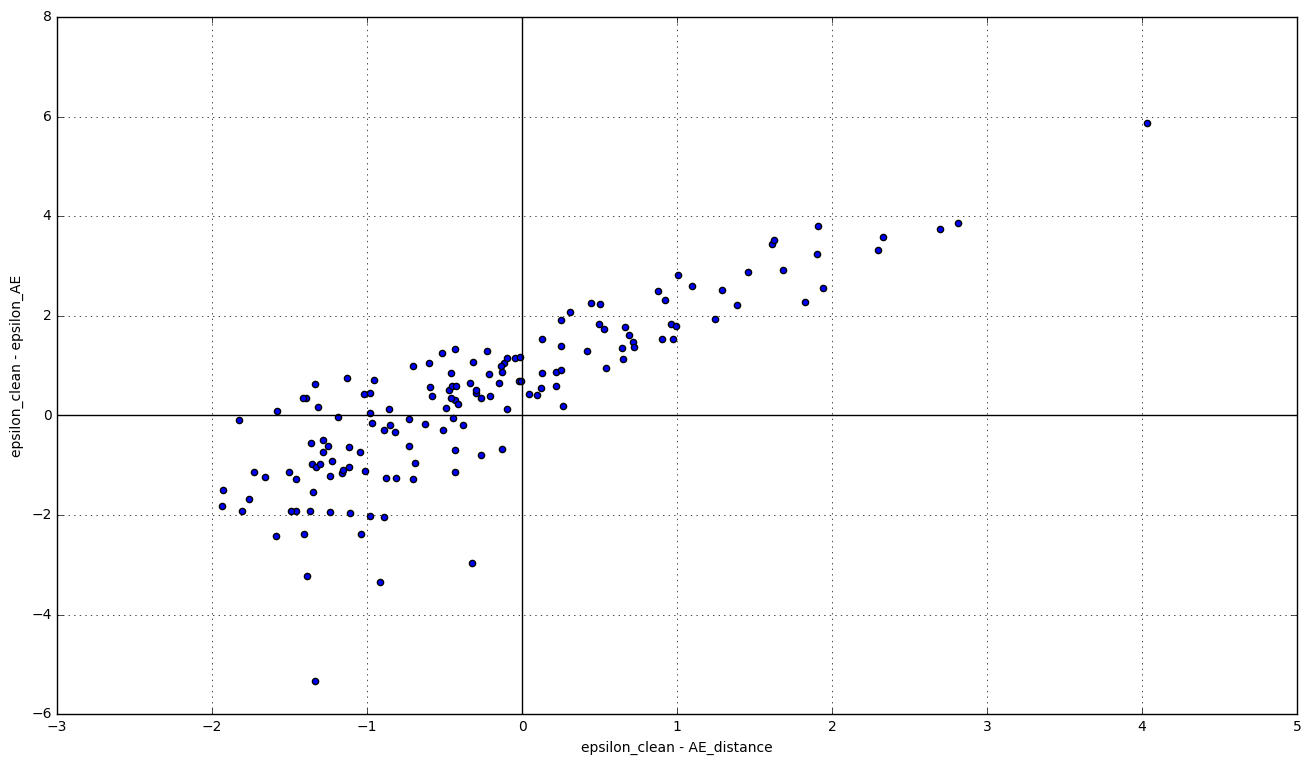

In [8]:
# Reproduce Evan's nice epsilon stability plot

data_set = 'I-FGM-2.00'

plt.figure()
x = epsilon_clean - delta_ae[data_set]
y = epsilon_clean - epsilon_ae[data_set]

plt.scatter(x,y)
plt.grid('on')
plt.xlabel('epsilon_clean - AE_distance')
plt.ylabel('epsilon_clean - epsilon_AE')
plt.title(data_set)
plt.axhline(0, color='k')
plt.axvline(0, color='k')
plt.show()

/Users/pekalmj1/anaconda3/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in less_equal


[info] There are 48 admissible points for this configuration


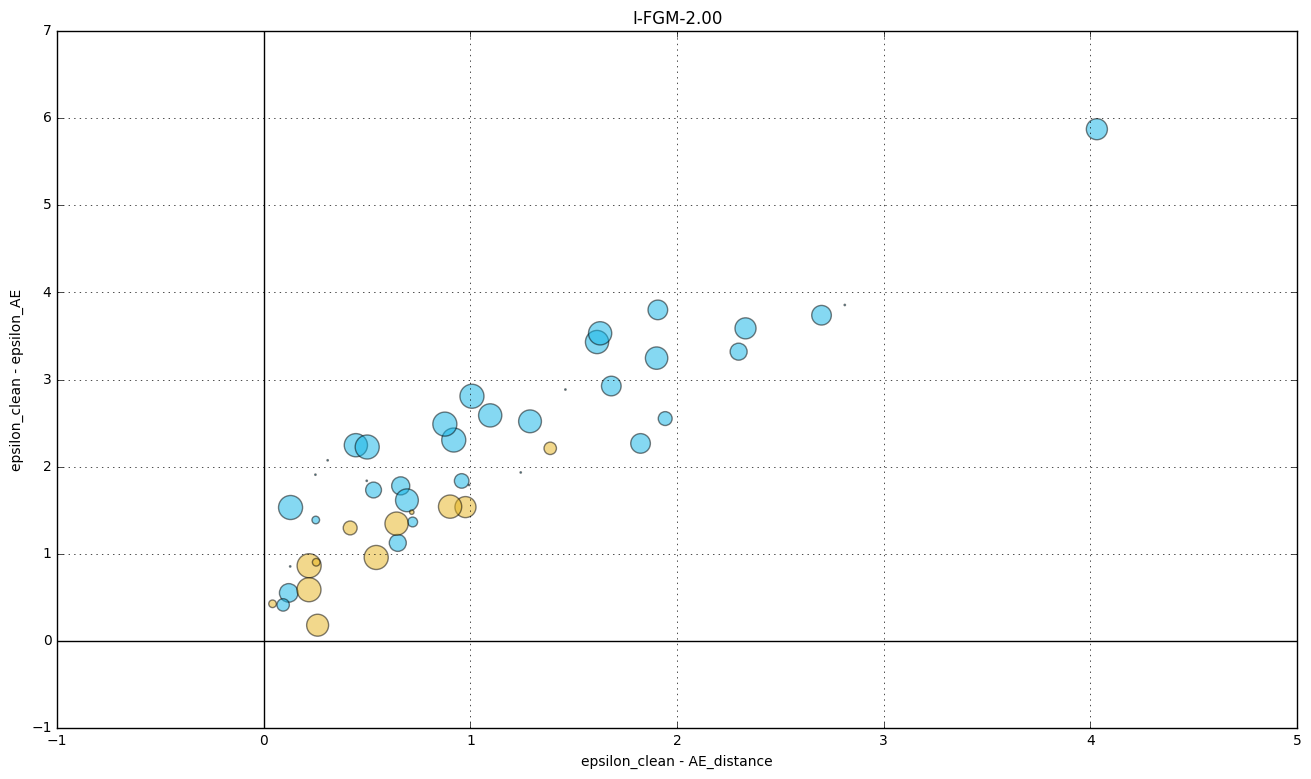

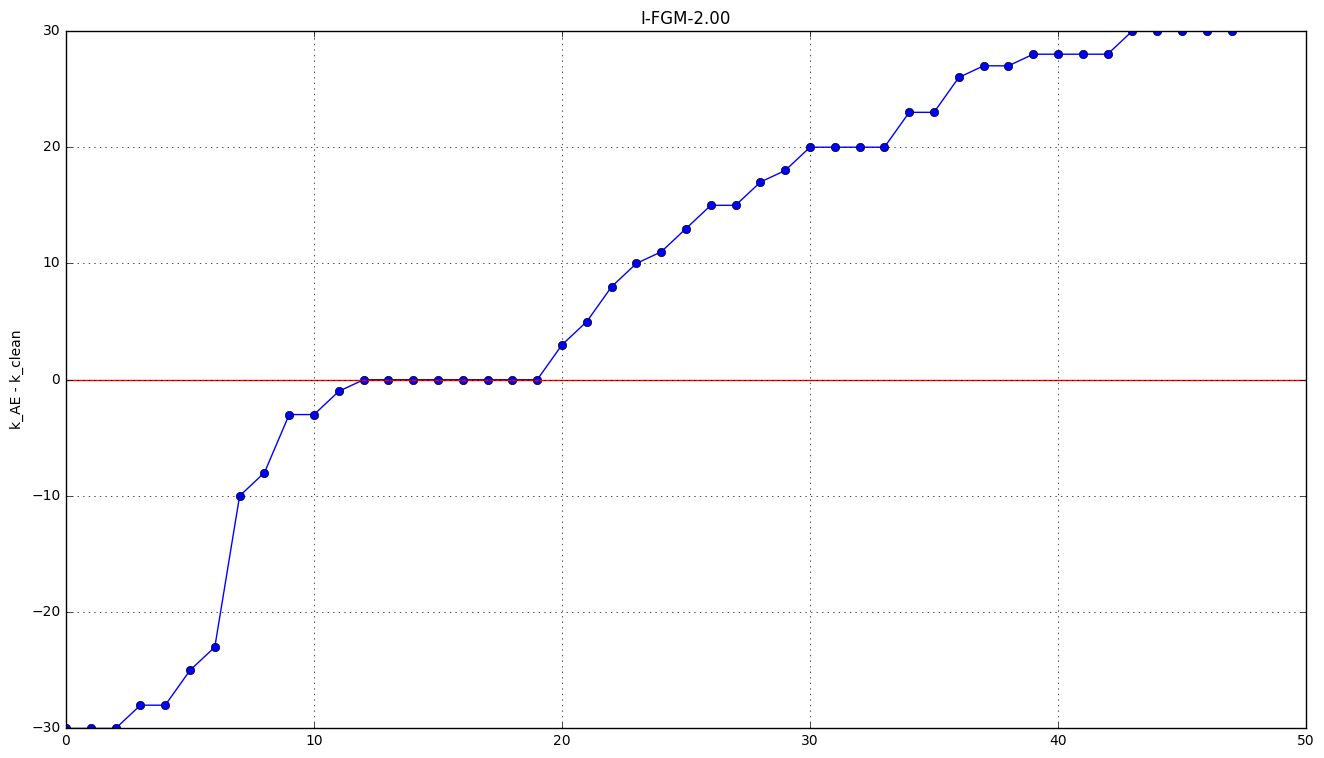

In [13]:
# compare some distributions

ae_data_sets = ['I-FGM-2.00']

for ds in ae_data_sets:   
    # We only care about AE within the epsilon-stable region of the original point.
    # i.e. we only care about quadrant I in the plot above.
    # We are not immediately concerned with the practicality of having such knowledge.   
    is_admissible = np.isfinite(delta_ae[ds]) & (delta_ae[ds] <= epsilon_clean)
    
    #is_admissible = np.isfinite(delta_ae[ds]) # TEMP - to see it all, not just Q1
    
    print('[info] There are %d admissible points for this configuration' % np.sum(is_admissible))
    
    # look at the relative AE dimensionality (i.e. delta k) in this region
    delta_k = k_max_ae[ds][is_admissible] - k_max_clean[is_admissible]
    
    
    # Some plots
    if True:
        # visualize the admissible subset - make sure is indeed Q1
        x = epsilon_clean[is_admissible] - delta_ae[ds][is_admissible]
        y = epsilon_clean[is_admissible] - epsilon_ae[ds][is_admissible]

        plt.figure()
        plt.axhline(0, color='k')
        plt.axvline(0, color='k')
        scatter3_2d(x, y, 1e-4+(10*delta_k))
        plt.xlabel('epsilon_clean - AE_distance')
        plt.ylabel('epsilon_clean - epsilon_AE')
        plt.title(ds)
        plt.grid('on')
    
    if True:
        plt.figure()
        plt.plot(np.sort(delta_k), '-o')
        plt.axhline(0, color='red')
        plt.ylabel('k_AE - k_clean')
        plt.title(ds)
        plt.grid('on')
          
    
plt.show()